In [1]:
import retire_convex as retire
import numpy as np
import numpy.random as rgt
import pandas as pd
from scipy.linalg import block_diag

In [2]:
n, p = 400, 200 

In [3]:
def groupTPFP(structure=np.array([]), estimated_hat = np.array([])):
    if estimated_hat.size != p:
        raise ValueError("estimated_hat must have length p") 
    
    number_of_groups = structure.size
    group_level_active_loc, group_level_active_loc_estimated = np.zeros(number_of_groups), np.zeros(number_of_groups)
    
    prev = 0
    for idx,val in enumerate(structure.cumsum()):
        if sum(true_loc[prev:val])>0:
            group_level_active_loc[idx] = 1
        if sum(estimated_hat[prev:val]) > 0 :
            group_level_active_loc_estimated[idx] = 1
        prev = val
    
    group_TP = sum(group_level_active_loc * group_level_active_loc_estimated)
    group_FP = sum( (1 - group_level_active_loc) * group_level_active_loc_estimated)
    
    group_TPR = group_TP / sum(group_level_active_loc)
    group_FPR = group_FP / sum(1 - group_level_active_loc)
    
    return [group_TPR, group_FPR]
       
                
def sim(tau_input=0.5, quantile=0, expectile=0, M=10, robust=(n/np.log(n*p))**0.5, \
        noise_type='normal', model_type='model1',
        alpha=0.5, w_vec=np.array([]), structure=np.array([]), problem_type="EN"): #L1, EN, GL, SGL
    print('model_type=',model_type, ' noise_type=',noise_type, ' robust=',round(robust,3))
    print('alpha=',alpha, ' w_vec=',np.round(w_vec,2), ' structure=',structure, ' problem_type=', problem_type)
    print("tau=",tau_input, ' expectile=',expectile, ' quantile=',quantile, ' M=', M, '\n')
    l2loss_min_vec, l2loss_1se_vec, TPR_min_vec, TPR_1se_vec, FPR_min_vec, FPR_1se_vec = np.zeros(M),np.zeros(M),np.zeros(M),np.zeros(M),np.zeros(M),np.zeros(M)
    group_TPR_min_vec, group_TPR_1se_vec, group_FPR_min_vec, group_FPR_1se_vec = np.zeros(M),np.zeros(M),np.zeros(M),np.zeros(M)   
    for m in range(M):
        rgt.seed(100+m)
        X = rgt.multivariate_normal(np.zeros(p), cov_matrix, size = n)
        
        if noise_type == 'normal':
            noise = rgt.normal(0,2**0.5,n) #sd=sqrt(2)
        elif noise_type == 't':
            noise = rgt.standard_t(2.1,n)
        else:
            raise ValueError("noise_type must be either normal, t")
            
        if model_type == 'model1':
            Y = itcp + X.dot(beta) + noise                                         #Homoscedastic 
        elif model_type == 'model2':
            Y = itcp + X.dot(beta) + (0.5 + 0.5*abs(X[:,-1]))*(noise - quantile)   #Quantile Hetero
        elif model_type == 'model3':
            Y = itcp + X.dot(beta) + (0.5 + 0.5*abs(X[:,-1]))*(noise - expectile)  #Expectile Hetero
        else:
            raise ValueError("model_type must be either model1, model2, model3")
        
        temp = retire.cv(X,Y)            
                
        result_temp = temp.fit(tau_input,robust=robust, scale_invariant=True, 
                 nfolds=10, standardize=True, adjust=True, CV_plot=True, CV_rule = 'both',   
                 alpha=alpha, w_vec=w_vec, structure=structure, problem_type=problem_type)
        
        TP_min, TP_1se, FP_min, FP_1se, l2loss_min, l2loss_1se= np.nan, np.nan, np.nan, np.nan, np.nan, np.nan        
        if result_temp['CV_rule']=='both' or result_temp['CV_rule']=='min':
            TP_min = ((result_temp['fit_result_min']['cv_beta']!=0)[1:] * true_loc).sum()  
            FP_min = result_temp['size_min'] - (result_temp['fit_result_min']['cv_beta']!=0)[0] - TP_min
            l2loss_min = (np.sum((result_temp['fit_result_min']['cv_beta'][1:] - beta)**2) + (result_temp['fit_result_min']['cv_beta'][0]-itcp)**2)**0.5 
            l2loss_min_vec[m] = l2loss_min
            if structure.size == 0:
                group_result_min = [np.nan,np.nan]
            else:
                group_result_min = groupTPFP(structure, (result_temp['fit_result_min']['cv_beta']!=0)[1:])
        
        if result_temp['CV_rule']=='both' or result_temp['CV_rule']=='1se':
            TP_1se = ((result_temp['fit_result_1se']['cv_beta']!=0)[1:] * true_loc).sum()         
            FP_1se = result_temp['size_1se'] - (result_temp['fit_result_1se']['cv_beta']!=0)[0] - TP_1se
            l2loss_1se = (np.sum((result_temp['fit_result_1se']['cv_beta'][1:] - beta)**2) + (result_temp['fit_result_1se']['cv_beta'][0]-itcp)**2)**0.5 
            l2loss_1se_vec[m] = l2loss_1se      
            if structure.size == 0:
                group_result_1se = [np.nan,np.nan]
            else:
                group_result_1se = groupTPFP(structure, (result_temp['fit_result_1se']['cv_beta']!=0)[1:])
            
        TPR_min, TPR_1se, FPR_min, FPR_1se = TP_min/len(true_active_set), TP_1se/len(true_active_set), FP_min/(p-len(true_active_set)), FP_1se/(p-len(true_active_set))
        TPR_min_vec[m], TPR_1se_vec[m], FPR_min_vec[m], FPR_1se_vec[m] = TPR_min, TPR_1se, FPR_min, FPR_1se
        
        group_TPR_min_vec[m], group_FPR_min_vec[m], group_TPR_1se_vec[m], group_FPR_1se_vec[m] = group_result_min[0], group_result_min[1], group_result_1se[0], group_result_1se[1]
        
        print('l2loss_min:' ,round(l2loss_min,3),' TPR_min:',round(TPR_min,3),' FPR_min:' ,round(FPR_min,3), ' group_TPR_min:', round(group_TPR_min_vec[m],3), ' group_FPR_min:', round(group_FPR_min_vec[m],3))
        print('l2loss_1se:' ,round(l2loss_1se,3),' TPR_1se:',round(TPR_1se,3), ' FPR_1se:',round(FPR_1se,3), ' group_TPR_1se:', round(group_TPR_1se_vec[m],3), ' group_TPR_1se:', round(group_FPR_1se_vec[m],3))        

    data_min = {'l2loss_min':l2loss_min_vec, 'TPR_min': TPR_min_vec, 'FPR_min': FPR_min_vec, 'group_TPR_min': group_TPR_min_vec, 'group_FPR_min': group_FPR_min_vec}
    data_1se = {'l2loss_1se':l2loss_1se_vec, 'TPR_1se': TPR_1se_vec, 'FPR_1se': FPR_1se_vec, 'group_TPR_1se': group_TPR_1se_vec, 'group_FPR_1se': group_FPR_1se_vec}
    df_min = pd.DataFrame(data_min)
    df_1se = pd.DataFrame(data_1se)
    df = pd.concat([df_min,df_1se],axis = 1)
    return(df)

In [4]:
M=1                                #number of repetition
model_type = 'model3'              #'model1' or 'model2' or 'model3'
tau_input = 0.5                    #0.5 or 0.8
noise_type = 'normal'              #'normal' or 't'
quantile = 0                       #depends on noise type and tau level
expectile = 0.0                    #depends on noise type and tau level
robust = (n/np.log(n*p))**0.5      #theoretic scale (n/np.log(n*p))**0.5 
alpha=0.5                          #hybrid level for the elastic net penalty

### A: Weighted Lasso

In [5]:
##sparse beta##
itcp, beta, true_loc = 4, np.zeros(p), np.zeros(p)
beta[:19] = [1.8, 0, 1.6, 0, 1.4, 0, 1.2, 0, 1, 0, -1, 0, -1.2, 0, -1.4, 0, -1.6, 0, -1.8] 
true_active_set = np.where(beta!=0)[0] 
true_loc[true_active_set] = 1           
structure = w_vec = np.array([])

##Cov matrix##
cov_matrix = np.zeros((p,p))
for i in range(p):
    for j in range(p):
        cov_matrix[i,j] = 0.7**abs(i-j)

model_type= model3  noise_type= normal  robust= 5.952
alpha= 0.5  w_vec= []  structure= []  problem_type= L1
tau= 0.5  expectile= 0.0  quantile= 0  M= 1 



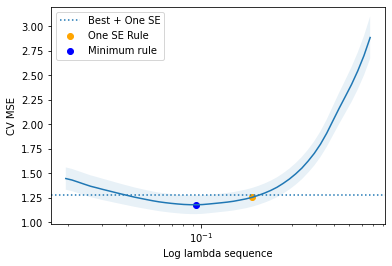

l2loss_min: 0.381  TPR_min: 1.0  FPR_min: 0.1  group_TPR_min: nan  group_FPR_min: nan
l2loss_1se: 0.6  TPR_1se: 1.0  FPR_1se: 0.011  group_TPR_1se: nan  group_TPR_1se: nan


In [6]:
problem_type='L1' 
df = sim(tau_input, quantile, expectile, M, robust, noise_type, model_type, alpha, 
         w_vec = w_vec, structure=structure, problem_type=problem_type)

### B: Elastic Net

In [7]:
##dense beta##
itcp, beta, true_loc = 4, np.zeros(p), np.zeros(p)
beta[:99] = 0.8 
true_active_set = np.where(beta!=0)[0]  
true_loc[true_active_set] = 1           
structure = w_vec = np.array([])

model_type= model3  noise_type= normal  robust= 5.952
alpha= 0.5  w_vec= []  structure= []  problem_type= EN
tau= 0.5  expectile= 0.0  quantile= 0  M= 1 



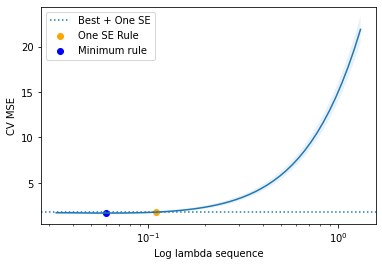

l2loss_min: 1.11  TPR_min: 1.0  FPR_min: 0.475  group_TPR_min: nan  group_FPR_min: nan
l2loss_1se: 0.985  TPR_1se: 1.0  FPR_1se: 0.317  group_TPR_1se: nan  group_TPR_1se: nan


In [8]:
problem_type='EN' 
df = sim(tau_input, quantile, expectile, M, robust, noise_type, model_type, alpha, 
         w_vec = w_vec, structure=structure, problem_type=problem_type)

### C: Group Lasso

In [9]:
##group beta##
itcp, beta, true_loc = 4, np.zeros(p), np.zeros(p)
beta[:5] = 2
beta[5:10] = 1.6
beta[10:20] = -2
beta[20:30] = 1
beta[30:40] = 0.6
true_active_set = np.where(beta!=0)[0]  
true_loc[true_active_set] = 1           
temp_val = int((p-40)/10)
structure = np.array([5,5,10,10,10,temp_val,temp_val,temp_val,temp_val,temp_val,temp_val,temp_val,temp_val,temp_val,temp_val])
w_vec=np.sqrt(structure)

##Cov matrix##
cov_matrix_sub1 = np.full((5,5), 0.6)
cov_matrix_sub2 = np.full((10,10), 0.6)
cov_matrix_sub3 = np.full((temp_val,temp_val), 0.6)
np.fill_diagonal(cov_matrix_sub1,1)
np.fill_diagonal(cov_matrix_sub2,1)
np.fill_diagonal(cov_matrix_sub3,1)
cov_matrix = block_diag(cov_matrix_sub1, cov_matrix_sub1, cov_matrix_sub2, cov_matrix_sub2, cov_matrix_sub2,\
                        cov_matrix_sub3, cov_matrix_sub3, cov_matrix_sub3, cov_matrix_sub3, cov_matrix_sub3,\
                        cov_matrix_sub3, cov_matrix_sub3, cov_matrix_sub3, cov_matrix_sub3, cov_matrix_sub3)

model_type= model3  noise_type= normal  robust= 5.952
alpha= 0.5  w_vec= [2.24 2.24 3.16 3.16 3.16 4.   4.   4.   4.   4.   4.   4.   4.   4.
 4.  ]  structure= [ 5  5 10 10 10 16 16 16 16 16 16 16 16 16 16]  problem_type= GL
tau= 0.5  expectile= 0.0  quantile= 0  M= 1 



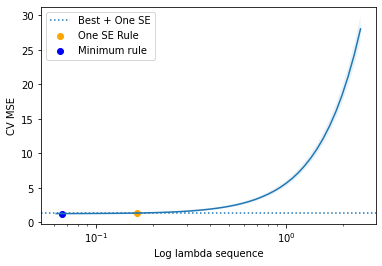

l2loss_min: 0.856  TPR_min: 1.0  FPR_min: 0.3  group_TPR_min: 1.0  group_FPR_min: 0.3
l2loss_1se: 0.777  TPR_1se: 1.0  FPR_1se: 0.0  group_TPR_1se: 1.0  group_TPR_1se: 0.0


In [10]:
problem_type='GL' 
df = sim(tau_input, quantile, expectile, M, robust, noise_type, model_type, alpha, 
         w_vec = w_vec, structure=structure, problem_type=problem_type)

### D: Sparse Group Lasso

In [11]:
##group sparse beta##
itcp, beta, true_loc = 4, np.zeros(p), np.zeros(p)
beta[:5] = [2,2,0,0,0]
beta[5:10] = [1.6, 1.6, 0, 0, 0]
beta[10:20] = [-2, -2, -2, -2, -2, 0, 0, 0, 0, 0]
beta[20:30] = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
beta[30:40] = [0.6, 0.6, 0.6, 0.6, 0.6, 0, 0, 0, 0, 0]
true_active_set = np.where(beta!=0)[0]  
true_loc[true_active_set] = 1           
temp_val = int((p-40)/10)
structure = np.array([5,5,10,10,10,temp_val,temp_val,temp_val,temp_val,temp_val,temp_val,temp_val,temp_val,temp_val,temp_val])
w_vec=np.sqrt(structure)

model_type= model3  noise_type= normal  robust= 5.952
alpha= 0.5  w_vec= [2.24 2.24 3.16 3.16 3.16 4.   4.   4.   4.   4.   4.   4.   4.   4.
 4.  ]  structure= [ 5  5 10 10 10 16 16 16 16 16 16 16 16 16 16]  problem_type= SGL
tau= 0.5  expectile= 0.0  quantile= 0  M= 1 



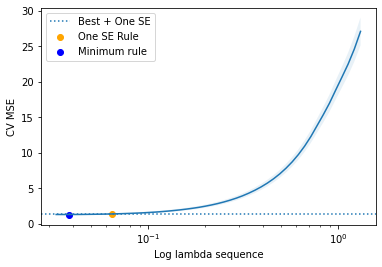

l2loss_min: 0.944  TPR_min: 1.0  FPR_min: 0.249  group_TPR_min: 1.0  group_FPR_min: 0.3
l2loss_1se: 1.103  TPR_1se: 1.0  FPR_1se: 0.155  group_TPR_1se: 1.0  group_TPR_1se: 0.1


In [12]:
problem_type='SGL' 
df = sim(tau_input, quantile, expectile, M, robust, noise_type, model_type, alpha, 
         w_vec = w_vec, structure=structure, problem_type=problem_type)